# Importing Dependencies

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import cv2
import os
import tensorflow as tf
from glob import glob
from tqdm import tqdm
import time

In [2]:
height = 1024//4
width = 1280//4

In [3]:
label = 3
img_path = './train/frames_3/frame004_seq_2.png'
label_path = './train/labels_3/frame004_seq_2.png'
train_path = './train/'
model_path = os.path.join('./model/unet_jacc_1.keras')
log_path = os.path.join('./log/', f'log_{label}_NEW.csv')
save_path = './save/'

In [4]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
create_dir(save_path)

In [6]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [7]:
model = tf.keras.models.load_model(model_path, custom_objects={'jaccard_distance': jaccard_distance})
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 320, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 320, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [8]:
def predict_mask(x):
    name = x.split('/')[-1]
    
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x/255.0
    x = np.expand_dims(x, axis=0)
    
    p = model.predict(x)[0]
    return p

In [9]:
X = glob(os.path.join(train_path, 'frames_3', '*'))
y = glob(os.path.join(train_path, f'labels_{label}', '*'))

In [10]:
def jaccard_index(y_true_path, y_pred):
    y_true = cv2.imread(y_true_path)
    y_pred = tf.image.resize(y_pred, (y_true.shape[0], y_true.shape[1]))

    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float64)  
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2]) - intersection
    jaccard = tf.reduce_mean((intersection + 1e-7) / (union + 1e-7))  
    
    return jaccard 

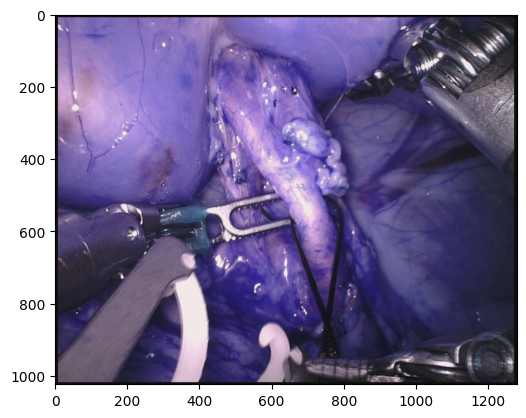

In [11]:
img = cv2.imread(img_path)
plt.imshow(img)

1/1 [==============================] - 8s 8s/step


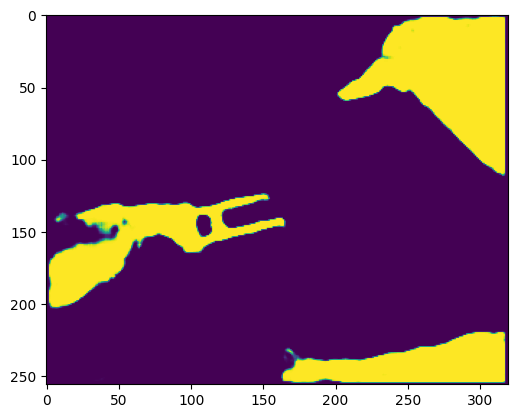

In [12]:
mask = predict_mask(img_path)
plt.imshow(mask)

In [ ]:
_list = []
for idx, x in enumerate(X):
    y_predicted = predict_mask(y[idx])
    _list.append(jaccard_index(y[idx],y_predicted))
    
print(sum(_list)/len(_list))

1/1 [==============================] - 0s 318ms/step
